In [1]:
from fktools import *
import tensorflow as tf
import sklearn
from dist_metric import DistributionOverlapSingle, DistributionOverlap
from time import time

2026-01-26 16:13:25.191862: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2026-01-26 16:13:25.234096: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2026-01-26 16:13:26.283973: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
/home/filip/miniconda3/envs/defects/lib/python3.11/site-packages/keras/src/export/tf2onnx_l

In [2]:
WALK_DIM = 8
LATENT_DIM = 2

X_FILE = "dataset_autoenc_3_X.npz"
Y_FILE = "dataset_autoenc_3_y.npz"

print(int(time()))

1769440406


In [3]:
class Autoencoder(tf.keras.Model):
    def __init__(self, latent_dim):
        super(Autoencoder, self).__init__()
        self.latent_dim = latent_dim

        self.encoder = tf.keras.Sequential([
            tf.keras.layers.Input(shape=(WALK_DIM,)),
            tf.keras.layers.Dense(latent_dim, activation='relu'),
        ])
        self.decoder = tf.keras.Sequential([
            tf.keras.layers.Dense(WALK_DIM, activation='softmax'),
        ])

    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded


latent_dim = LATENT_DIM
autoencoder = Autoencoder(latent_dim)

I0000 00:00:1769440406.664258   10089 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 974 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3060, pci bus id: 0000:01:00.0, compute capability: 8.6


In [4]:
X = np.load(X_FILE, allow_pickle=True)['arr_0']
y = np.load(Y_FILE, allow_pickle=True)['arr_0']

print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")


X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X, y, test_size=0.2)

print(f"X train size: {X_train.shape}")
print(f"X test size: {X_test.shape}")

X shape: (52592, 8)
y shape: (52592, 3)
X train size: (42073, 8)
X test size: (10519, 8)


In [5]:
autoencoder.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001),
    loss=tf.keras.losses.KLDivergence(),
    metrics=[DistributionOverlap()]
)

history = autoencoder.fit(
    X_train, X_train,
    epochs=50,
    batch_size=32,
    validation_split = 0.2,
)

Epoch 1/50


2026-01-26 16:13:27.651169: I external/local_xla/xla/service/service.cc:163] XLA service 0x7db37c003d10 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2026-01-26 16:13:27.651185: I external/local_xla/xla/service/service.cc:171]   StreamExecutor device (0): NVIDIA GeForce RTX 3060, Compute Capability 8.6
2026-01-26 16:13:27.664136: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2026-01-26 16:13:27.741901: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:473] Loaded cuDNN version 91701


 178/1052 ━━━━━━━━━━━━━━━━━━━━ 0s 863us/step - dist_overlap: 0.4401 - loss: 0.9862

I0000 00:00:1769440408.349394   16269 device_compiler.h:196] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1052/1052 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - dist_overlap: 0.5781 - loss: 0.6226 - val_dist_overlap: 0.6913 - val_loss: 0.3407
Epoch 2/50
1052/1052 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - dist_overlap: 0.7167 - loss: 0.2905 - val_dist_overlap: 0.7404 - val_loss: 0.2512
Epoch 3/50
1052/1052 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - dist_overlap: 0.7707 - loss: 0.2097 - val_dist_overlap: 0.8009 - val_loss: 0.1684
Epoch 4/50
1052/1052 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - dist_overlap: 0.8237 - loss: 0.1394 - val_dist_overlap: 0.8432 - val_loss: 0.1178
Epoch 5/50
1052/1052 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - dist_overlap: 0.8561 - loss: 0.1028 - val_dist_overlap: 0.8669 - val_loss: 0.0921
Epoch 6/50
1052/1052 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - dist_overlap: 0.8757 - loss: 0.0830 - val_dist_overlap: 0.8825 - val_loss: 0.0767
Epoch 7/50
1052/1052 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - dist_overlap: 0.8883 - loss: 0.0705 - val_dist_overlap: 0.8925 - val_loss: 0.0668
Epoch 8/50
1052/1052 ━━━━━━━━━━━━━━━━━━━━ 1s 

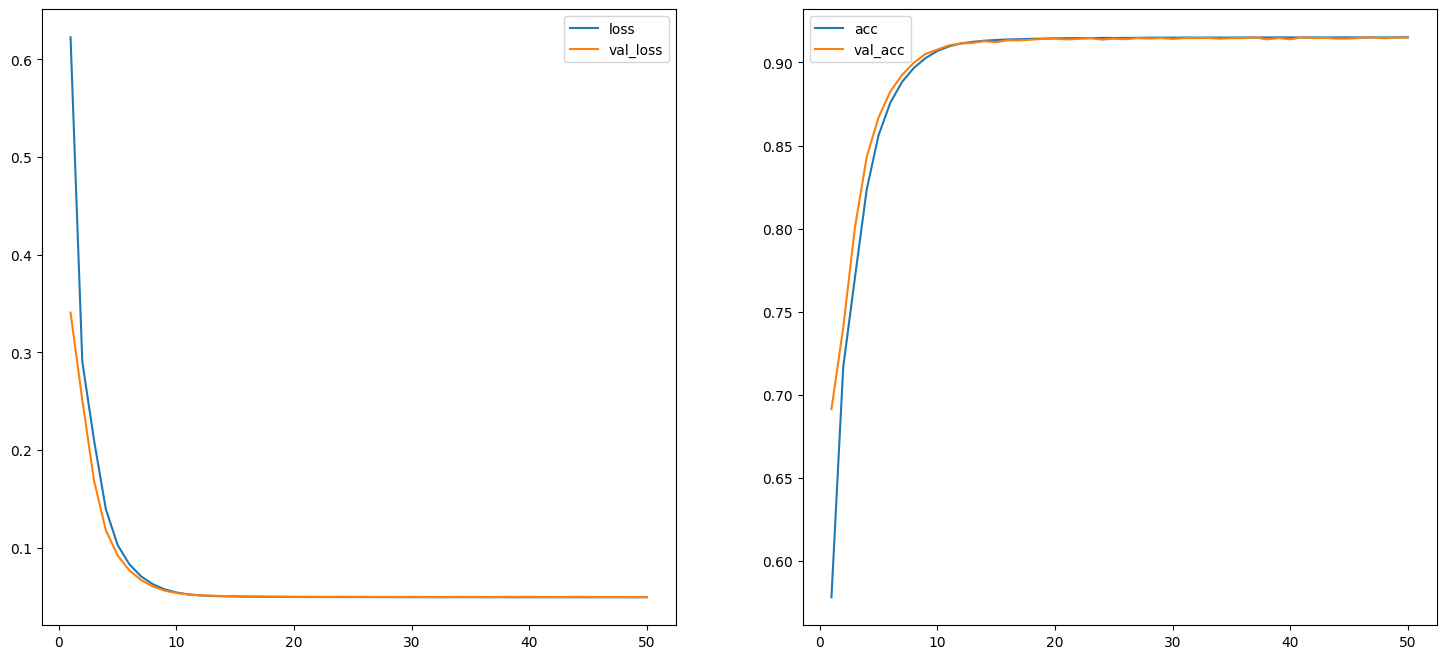

In [18]:
loss = history.history['loss']
acc = history.history['dist_overlap']

val_loss = history.history['val_loss']
val_acc = history.history['val_dist_overlap']

epochs = range(1, len(loss) + 1)

fig, ax = plt.subplots(ncols=2, figsize=(18,8))
ax[0].plot(epochs, loss, label="loss")
ax[0].plot(epochs, val_loss, label="val_loss")
ax[0].legend()
ax[1].plot(epochs, acc, label="acc")
ax[1].plot(epochs, val_acc, label="val_acc")
ax[1].legend()

329/329 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


<BarContainer object of 8 artists>

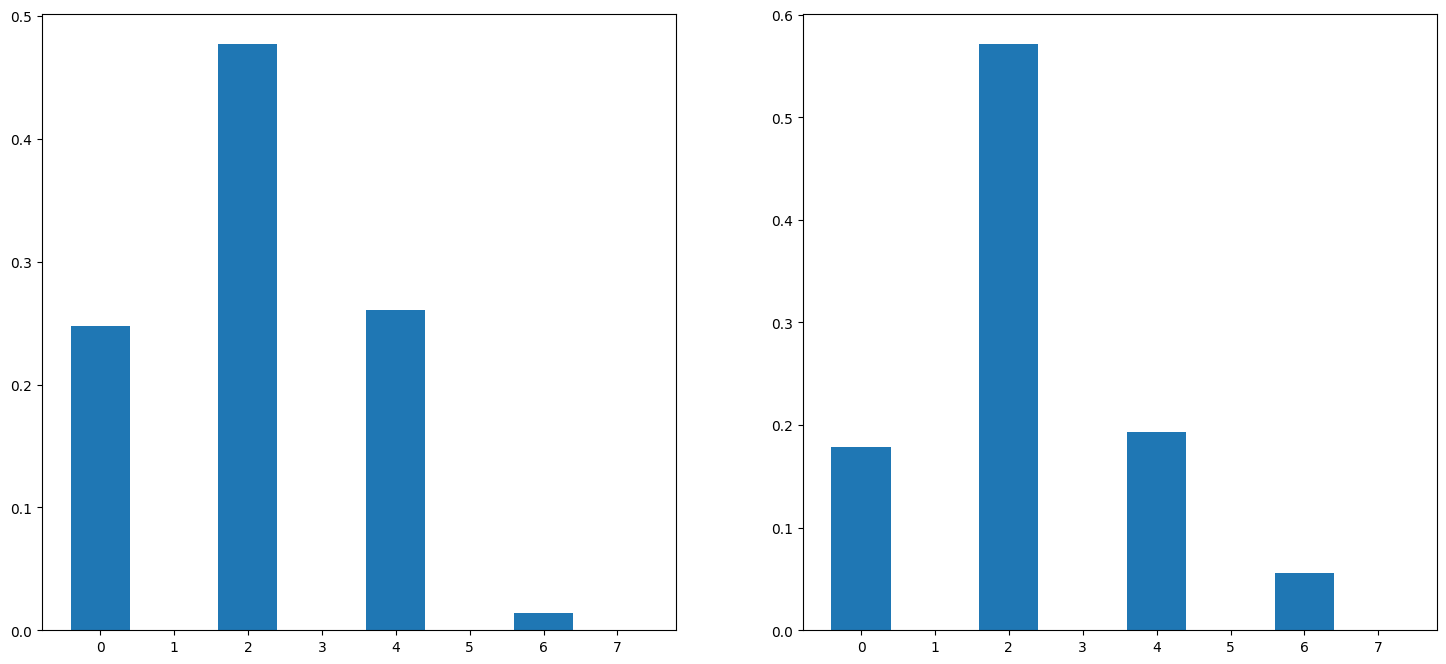

In [8]:
i = 1

pred = autoencoder.predict(X_test)

fig, ax = plt.subplots(ncols=2, figsize=(18,8))

ax[0].bar(np.arange(WALK_DIM), X_test[i])
ax[1].bar(np.arange(WALK_DIM), pred[i])

[[8.88138    0.6740701 ]
 [3.0374782  8.937974  ]
 [7.8253226  2.235208  ]
 ...
 [1.2510626  8.651326  ]
 [4.6045065  0.5724058 ]
 [7.4570694  0.60661054]]


Text(0.5, 1.0, 'autoencoder 8-2-8, encoded points')

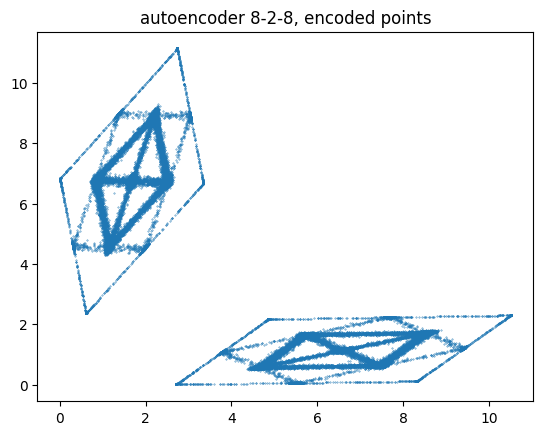

In [9]:
encoded_points = np.array(autoencoder.encoder(X))

print(encoded_points)

np.savez_compressed(f"autoencoder_{WALK_DIM}-{LATENT_DIM}-{WALK_DIM}_encodedpoints_{int(time())}", encoded_points)

plt.scatter(encoded_points[:,0], encoded_points[:,1],s=0.1)
plt.title(f"autoencoder {WALK_DIM}-{LATENT_DIM}-{WALK_DIM}, encoded points")

In [10]:
print(tf.keras.losses.KLD(X_test, pred))
print(np.mean(tf.keras.losses.KLD(X_test, pred)))

tf.Tensor([0.08335279 0.05363968 0.08959904 ... 0.10340458 0.00036244 0.01287079], shape=(10519,), dtype=float32)
0.049003195


In [11]:
encoded_with_params = np.array(autoencoder.encoder(X))



encoded_with_params[:,0] /= np.max(encoded_with_params[:,0])
encoded_with_params[:,1] /= np.max(encoded_with_params[:,1])

Text(0.5, 1.0, 'color is number of steps')

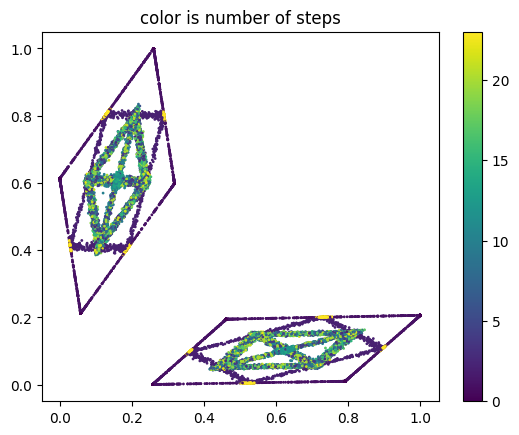

In [12]:
plt.scatter(encoded_with_params[y[:,0]<24,0], encoded_with_params[y[:,0]<24,1], s=1, c=y[y[:,0]<24,0])
plt.colorbar()
plt.title("color is number of steps")

Text(0.5, 1.0, 'color is number of steps')

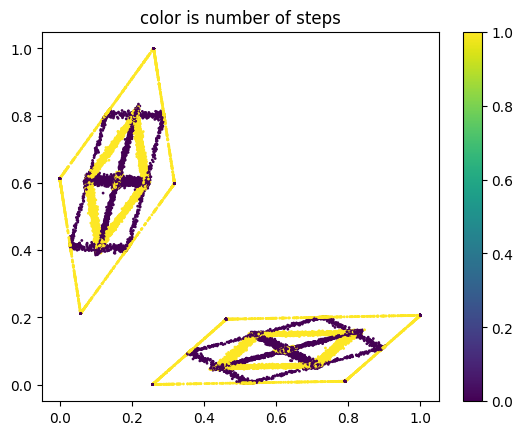

In [13]:
plt.scatter(encoded_with_params[:,0], encoded_with_params[:,1], s=1, c=y[:,0]%2)
plt.colorbar()
plt.title("color is number of steps")

Text(0.5, 1.0, 'color is start position')

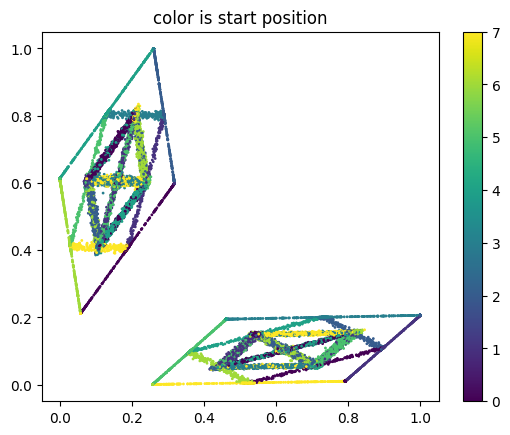

In [14]:
plt.scatter(encoded_with_params[:,0], encoded_with_params[:,1], s=1, c=y[:,1])
plt.colorbar()
plt.title("color is start position")

Text(0.5, 1.0, 'color is coin phase')

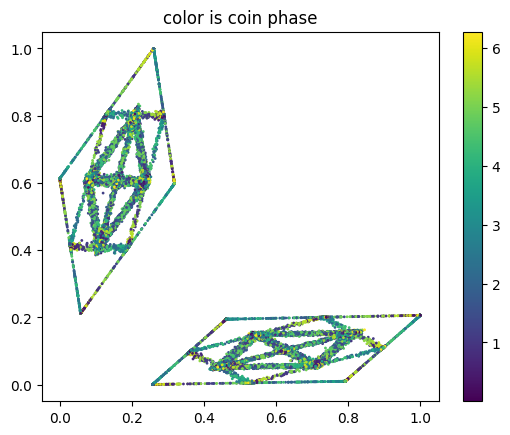

In [15]:
plt.scatter(encoded_with_params[:,0], encoded_with_params[:,1], s=1, c=y[:,2])
plt.colorbar()
plt.title("color is coin phase")

In [16]:
from sklearn.decomposition import PCA

pca = PCA()
pca.fit(encoded_with_params)
print(pca.explained_variance_ratio_)



[0.89328563 0.10671436]
